In [2]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from astropy import units
from pathlib import Path
import os

import snapshot_obj
import dataset_compute

import importlib

In [4]:
importlib.reload(snapshot_obj)
importlib.reload(dataset_compute)

<module 'dataset_compute' from '/home/kassiili/Curvaton_Simulations/analysis/dataset_compute.py'>

# Central mass distribution of satellites of M31 and MW

Count the accumulation of satellites with $v_\mathrm{max}$ from the centres of potential of the MW and M31 galaxies **separately**.

Create a dictionary of the datasets from each simulation. 

In [5]:
snap_id = 127
sim_ids = ["V1_LR_fix", "V1_LR_curvaton_p082_fix", "V1_LR_curvaton_p084_fix"]
names = ["LCDM", "p082", "p084"]
paths = ["", "/media/kassiili/USBFREE/LG_simulations", 
        "/media/kassiili/USBFREE/LG_simulations"]

# Define M31 and MW in each simulation:
m31 = [(1,0), (1,0), (1,0)]
mw = [(2,0), (1,1), (1,0)]

data = {}
for name, sim_id, sim_path, m31_ns, mw_ns in zip(names, sim_ids, paths, m31, mw):
    data[name] = {"snapshot": snapshot_obj.Snapshot(sim_id, snap_id, name=name,
                                                    sim_path=sim_path),
                  "M31_identifier": m31_ns,
                  "MW_identifier": mw_ns}

In [6]:
z = data["LCDM"]["snapshot"].get_attribute("Redshift", "Header")

## Get data for plotting

Choose how to distinguish between satellites and isolated:

In [7]:
distinction = "by_gn"

Read the datasets from each simulation, convert the units and split into satellites/isolated and luminous/dark:

In [8]:
def arrange_v1kpc_array(v1kpc):
    v1kpc = np.concatenate((np.sort(v1kpc)[::-1], np.array([0.01]))) 
    return v1kpc

def construct_count_array(size):
    return np.concatenate((np.arange(1, size+1), 
                           np.array([size])))

In [9]:
for key, sim_data in data.items():    
    # Get data:
    snap = sim_data["snapshot"]
    v1kpc = snap.get_subhalos("V1kpc", "Extended") * units.cm.to(units.km)
    
    # Add M31 and MW to the dictionary:
    idx_m31 = snap.index_of_halo(sim_data["M31_identifier"][0], sim_data["M31_identifier"][1])
    sim_data["M31"] = {"V1kpc": v1kpc[idx_m31]}
    idx_mw = snap.index_of_halo(sim_data["MW_identifier"][0], sim_data["MW_identifier"][1])
    sim_data["MW"] = {"V1kpc": v1kpc[idx_mw]}
    
    # Compute masking arrays:
    mask_lum, mask_dark = dataset_compute.split_luminous(snap)
    mask_nonzero_vmax = dataset_compute.prune_vmax(snap)
    if distinction == "by_r":
        mask_sat, mask_isol = dataset_compute.split_satellites_by_distance(
            snap, sim_data["M31_identifier"], sim_data["MW_identifier"])
    elif distinction == "by_gn":
        mask_sat, mask_isol = dataset_compute.split_satellites_by_group_number(
            snap, sim_data["M31_identifier"], sim_data["MW_identifier"])
    
    mask_m31_lum = np.logical_and.reduce([mask_sat[0], mask_lum, mask_nonzero_vmax])
    mask_m31_dark = np.logical_and.reduce([mask_sat[0], mask_dark, mask_nonzero_vmax])
    mask_mw_lum = np.logical_and.reduce([mask_sat[1], mask_lum, mask_nonzero_vmax])
    mask_mw_dark = np.logical_and.reduce([mask_sat[1], mask_dark, mask_nonzero_vmax])
    mask_isol_lum = np.logical_and.reduce([mask_isol, mask_lum, mask_nonzero_vmax])
    mask_isol_dark = np.logical_and.reduce([mask_isol, mask_dark, mask_nonzero_vmax])
    
    # In case M31 and MW are identified as the same halo, remove intersection:
    mask_mw_lum = np.logical_and(mask_mw_lum, np.logical_not(mask_m31_lum))
    mask_mw_dark = np.logical_and(mask_mw_dark, np.logical_not(mask_m31_dark))
   
    # Add M31 satellites to the dictionary:
    sim_data["M31_satellites"] = \
    {"V1kpc": {"luminous": arrange_v1kpc_array(v1kpc[mask_m31_lum]),
                "dark": arrange_v1kpc_array(v1kpc[mask_m31_dark])
               },
     "sat_count": {"luminous": construct_count_array(np.sum(mask_m31_lum)),
                   "dark": construct_count_array(np.sum(mask_m31_dark))
                  }
    }
    
    # Add MW satellites to the dictionary:
    sim_data["MW_satellites"] = \
    {"V1kpc": {"luminous": arrange_v1kpc_array(v1kpc[mask_mw_lum]),
                "dark": arrange_v1kpc_array(v1kpc[mask_mw_dark])
               },
     "sat_count": {"luminous": construct_count_array(np.sum(mask_mw_lum)),
                   "dark": construct_count_array(np.sum(mask_mw_dark))
                  }
    }
        
    # Add all satellites combined to the dictionary:
    sim_data["all_satellites"] = \
    {"V1kpc": {"luminous": arrange_v1kpc_array(
        np.concatenate([v1kpc[mask_m31_lum], v1kpc[mask_mw_lum]])),
                "dark": arrange_v1kpc_array(
        np.concatenate([v1kpc[mask_m31_dark], v1kpc[mask_mw_dark]]))
               },
     "sat_count": {"luminous": construct_count_array(
         np.sum(np.logical_or(mask_m31_lum, mask_mw_lum))),
                   "dark": construct_count_array(
         np.sum(np.logical_or(mask_m31_dark, mask_mw_dark)))
                  }
    }
       
    # Add isolated galaxies to the dictionary:
    sim_data["isolated"] = \
    {"V1kpc": {"luminous": arrange_v1kpc_array(v1kpc[mask_isol_lum]),
                "dark": arrange_v1kpc_array(v1kpc[mask_isol_dark])
               },
     "sat_count": {"luminous": construct_count_array(np.sum(mask_isol_lum)),
                   "dark": construct_count_array(np.sum(mask_isol_dark))
                  }
    }

## Plot M31 and MW separately

In [10]:
# Set some parameters:
x_down = 5; x_up = 100
y_down = 1; y_up = 100

# Set colors:
color = ["black", "red", "blue", "green"]

In [11]:
# Construct saving location:
filename = 'sat_central_mass_dist_M31andMW_{}'.format(distinction)
for name in names:
    filename += "_{}".format(name)
filename += "_{}.png".format(snap_id)
    
home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")
filename = os.path.join(path, filename)

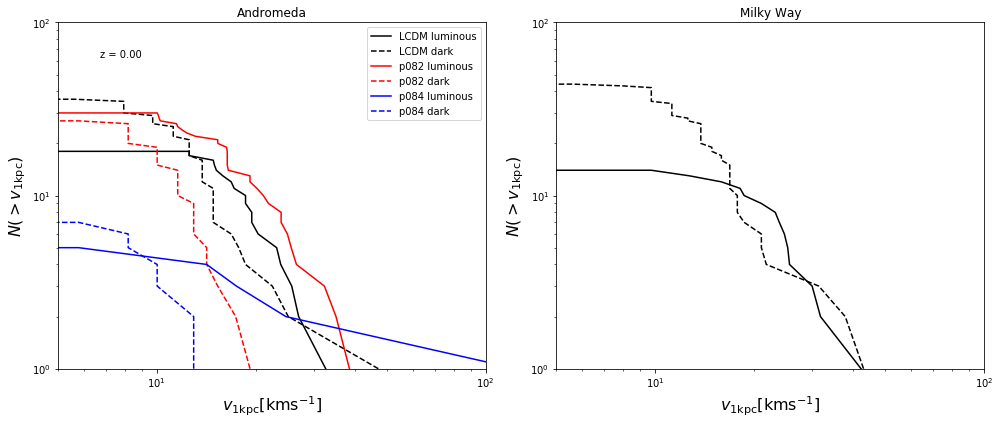

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
plt.subplots_adjust(wspace=0.3)

# Set axis:
for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(x_down, x_up)
    ax.set_ylim(y_down, y_up)
    ax.set_xlabel('$v_{\mathrm{1 kpc}}[\mathrm{km s^{-1}}]$', fontsize=16)
    ax.set_ylabel('$N(>v_{\mathrm{1 kpc}})$', fontsize=16)

# Add redshift:
z_x = 10 ** (np.log10(x_up) - 9/10 * (np.log10(x_up)-np.log10(x_down)))
z_y = 10 ** (np.log10(y_up) - 1/10 * (np.log10(y_up)-np.log10(y_down)))
axes[0].text(z_x, z_y, "z = {:.2f}".format(z))
    
axes[0].set_title('Andromeda')
axes[1].set_title('Milky Way')

# Add scatter plots:
for i, (name, entry) in enumerate(data.items()):
    x = entry['M31_satellites']['V1kpc']['luminous']
    y = entry['M31_satellites']['sat_count']['luminous']
    axes[0].plot(x, y, c=color[i], label='{} luminous'.format(name))
    
    x = entry['M31_satellites']['V1kpc']['dark']
    y = entry['M31_satellites']['sat_count']['dark']
    axes[0].plot(x, y, c=color[i], linestyle='--', label='{} dark'.format(name))
    
    x = entry['MW_satellites']['V1kpc']['luminous']
    y = entry['MW_satellites']['sat_count']['luminous']
    axes[1].plot(x, y, c=color[i], label='{} luminous'.format(name))
    
    x = entry['MW_satellites']['V1kpc']['dark']
    y = entry['MW_satellites']['sat_count']['dark']
    axes[1].plot(x, y, c=color[i], linestyle='--', label='{} dark'.format(name))

axes[0].legend(loc='upper right')
plt.tight_layout()

plt.savefig(filename, dpi=200)

## Plot all satellites and isolated galaxies

In [13]:
# Set some parameters:
x_down = 5; x_up = 100
y_down = 1; y_up = 1000

# Set colors:
color = ["black", "red", "blue", "green"]

In [14]:
# Construct saving location:
filename = 'sat_and_isol_central_mass_dist_{}'.format(distinction)
for name in names:
    filename += "_{}".format(name)
filename += "_{}.png".format(snap_id)
    
home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")
filename = os.path.join(path, filename)

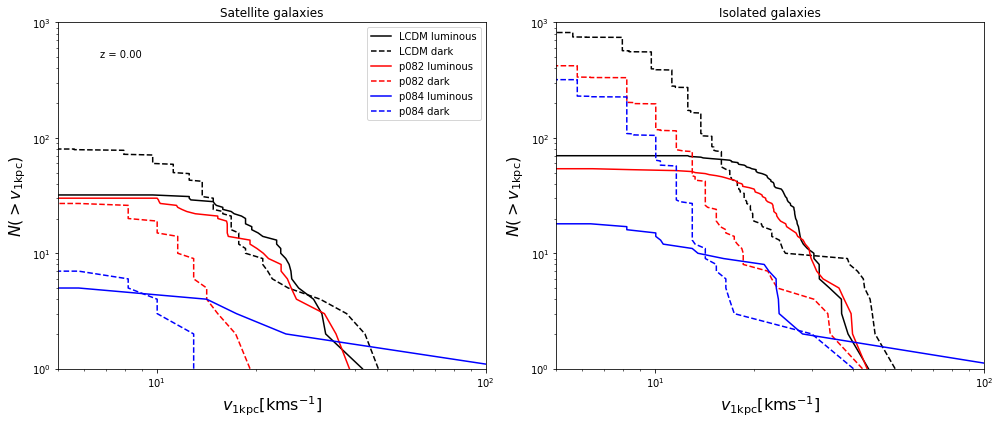

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(14,6))
plt.subplots_adjust(wspace=0.3)

# Set axis:
for ax in axes:
    ax.set_xlim(x_down, x_up)
    ax.set_ylim(y_down, y_up)
    ax.set_xlabel('$v_{\mathrm{1 kpc}}[\mathrm{km s^{-1}}]$', fontsize=16)
    ax.set_ylabel('$N(>v_{\mathrm{1 kpc}})$', fontsize=16)
    ax.set_xscale('log')
    ax.set_yscale('log')

# Add redshift:
z_x = 10 ** (np.log10(x_up) - 9/10 * (np.log10(x_up)-np.log10(x_down)))
z_y = 10 ** (np.log10(y_up) - 1/10 * (np.log10(y_up)-np.log10(y_down)))
axes[0].text(z_x, z_y, "z = {:.2f}".format(z))
    
axes[0].set_title('Satellite galaxies')
axes[1].set_title('Isolated galaxies')

# Add scatter plots:
for i, (name, entry) in enumerate(data.items()):
    x = entry['all_satellites']['V1kpc']['luminous']
    y = entry['all_satellites']['sat_count']['luminous']
    axes[0].plot(x, y, c=color[i], label='{} luminous'.format(name))
    
    x = entry['all_satellites']['V1kpc']['dark']
    y = entry['all_satellites']['sat_count']['dark']
    axes[0].plot(x, y, c=color[i], linestyle='--', label='{} dark'.format(name))
    
    x = entry['isolated']['V1kpc']['luminous']
    y = entry['isolated']['sat_count']['luminous']
    axes[1].plot(x, y, c=color[i], label='{} luminous'.format(name))
    
    x = entry['isolated']['V1kpc']['dark']
    y = entry['isolated']['sat_count']['dark']
    axes[1].plot(x, y, c=color[i], linestyle='--', label='{} dark'.format(name))

axes[0].legend(loc='upper right')
plt.tight_layout()

plt.savefig(filename, dpi=200)